In [108]:
import numpy as np
import numpy.linalg as la
import scipy.optimize as sopt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from random import random, seed
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from jax import grad

In [109]:
def design_matrix_1d(x, order):
    'design matrix construction for a 1d polynomial'
    'x = x datapoints, order = order of the polynomial'
    
    if len(x.shape) > 1:
        x = np.ravel(x)

    X = np.zeros((len(x), order+1))
    for i in range(order+1):
        X[:, i] = x**i

    return X

def MSE(y_data, y_model):
    'mean squared error calculation'
    'y_data = true y datapoints, y_model = predicted y datapoints'
    
    n = np.size(y_model)
    
    return np.sum((y_data-y_model)**2)/n

In [110]:
def GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1, momentum, change):
    'calculates gradient descent for a 1d polynomial'
    'npoints = number of datapoints, x = x datapoints, y = y datapoints, order = polynomial order'
    'lmbda = optional regularization parameter, niterations = number of iterations'
    'eta = learning rate, linreg0_ridge1 = 0 if you want linear reg, 1 if you want ridge'
    'momentum = optional momentum value, change = optional change value for momentum GD'

    X = design_matrix_1d(x, order)
    
    # intiialize guesses for beta parameters, correct values plus large noise (0.5 std)
    np.random.seed(2)
    beta = np.array([4, 3, 2]) + np.random.normal(0, 0.5, size=order+1)
    beta = np.expand_dims(beta, axis=1)
    

    for iter in range(niterations):
        
        # calculate gradients for either linear reg or ridge reg
        if linreg0_ridge1 == 0:
            gradient = (2.0 / npoints) * X.T @ (X @ beta-y)
        elif linreg0_ridge1 == 1:
            gradient = (2.0 / npoints) * X.T @ (X @ (beta)-y) + 2 * lmbda * beta
        
        # if doing momentum gradient descent, update betas with momentum * change
        if momentum != 0:
        
            new_change = eta * gradient + momentum * change

            beta -= new_change

            change = new_change

        # or do regular GD with just learning rate * gradient       
        else:
            
            beta -= eta * gradient
    
    # return the predicted y values
    ypred = X @ beta

    return ypred

# Plain GD Manually Adjusting Learning Rate

### Here we do manual adjustments of the learning rate eta for 4 values, and show the massive differences in being able to converge to correct prediction values

In [111]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)
order = 2

lmbda = 0.01
niterations = 100
eta1 = 0.0001
eta2 = 0.001
eta3 = 0.01
eta4 = 0.2

ypred_plain_OLS_eta1 = GD(npoints, x, y, order, lmbda, niterations, eta1, linreg0_ridge1=0, momentum=0, change=0)
ypred_plain_OLS_eta2 = GD(npoints, x, y, order, lmbda, niterations, eta2, linreg0_ridge1=0, momentum=0, change=0)
ypred_plain_OLS_eta3 = GD(npoints, x, y, order, lmbda, niterations, eta3, linreg0_ridge1=0, momentum=0, change=0)
ypred_plain_OLS_eta4 = GD(npoints, x, y, order, lmbda, niterations, eta4, linreg0_ridge1=0, momentum=0, change=0)

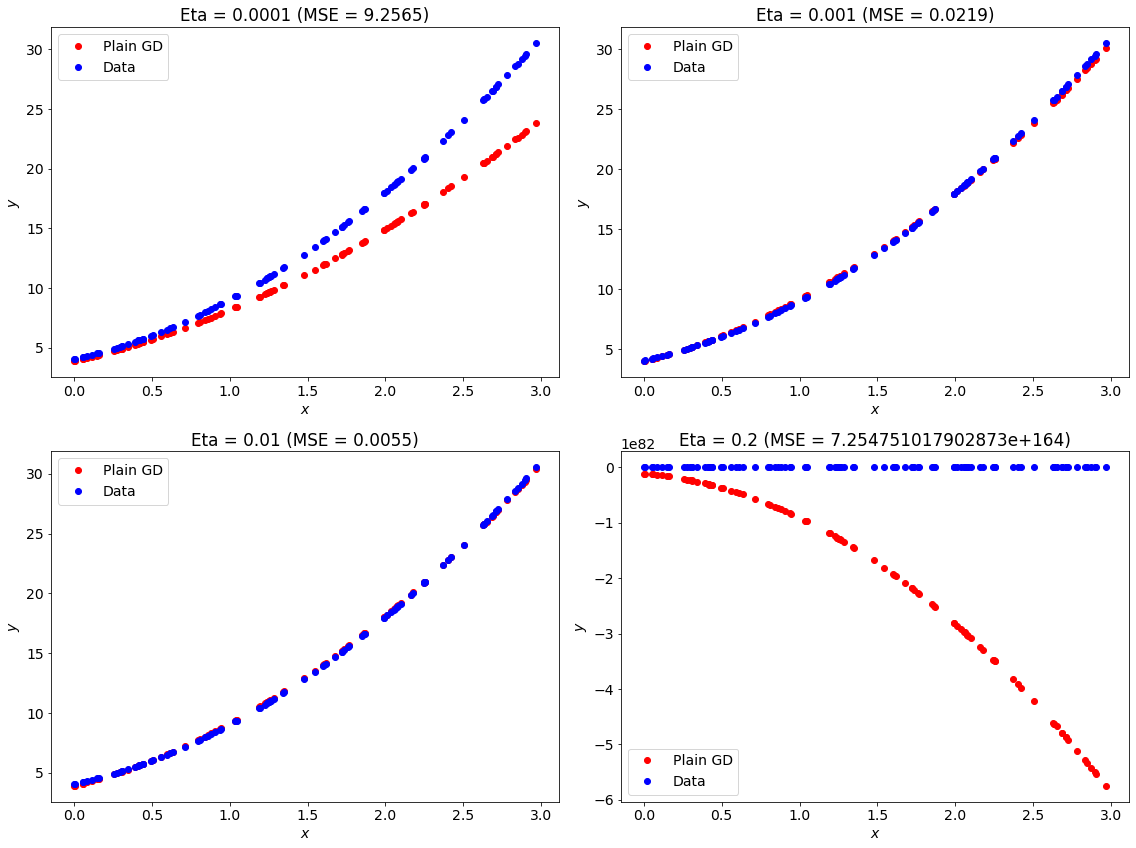

In [112]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(2, 2, figsize=(16,12))
ax[0,0].plot(x, ypred_plain_OLS_eta1, 'ro', label='Plain GD')
ax[0,0].plot(x, y ,'bo', label='Data')
ax[0,0].set_xlabel(r'$x$')
ax[0,0].set_ylabel(r'$y$')
ax[0,0].set_title('Eta = 0.0001 (MSE = '+str(round(MSE(ypred_plain_OLS_eta1, y),4)) + ')')
ax[0,0].legend()

ax[0,1].plot(x, ypred_plain_OLS_eta2, 'ro', label='Plain GD')
ax[0,1].plot(x, y ,'bo', label='Data')
ax[0,1].set_xlabel(r'$x$')
ax[0,1].set_ylabel(r'$y$')
ax[0,1].set_title('Eta = 0.001 (MSE = '+str(round(MSE(ypred_plain_OLS_eta2, y),4)) + ')')
ax[0,1].legend()

ax[1,0].plot(x, ypred_plain_OLS_eta3, 'ro', label='Plain GD')
ax[1,0].plot(x, y ,'bo', label='Data')
ax[1,0].set_xlabel(r'$x$')
ax[1,0].set_ylabel(r'$y$')
ax[1,0].set_title('Eta = 0.01 (MSE = '+str(round(MSE(ypred_plain_OLS_eta3, y),4)) + ')')
ax[1,0].legend()

ax[1,1].plot(x, ypred_plain_OLS_eta4, 'ro', label='Plain GD')
ax[1,1].plot(x, y ,'bo', label='Data')
ax[1,1].set_xlabel(r'$x$')
ax[1,1].set_ylabel(r'$y$')
ax[1,1].set_title('Eta = 0.2 (MSE = '+str(round(MSE(ypred_plain_OLS_eta4, y),4)) + ')')
ax[1,1].legend()
#fig.suptitle('Gradient Descent for OLS with Various Learning Rates (100 iterations)', fontsize=20)
plt.tight_layout()
fig.savefig('GD_plain_manual_tuning.jpg', dpi=1000, bbox_inches='tight')

# Momentum GD vs Plain GD

### Here we compare plain gradient descent with momentum gradient descent to show faster and better convergence of momentum GD

In [113]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2 + np.random.normal(0,0.1)
order = 2

lmbda = 0.01
niterations = 100
momentum = 0.2
change = 0.01
eta = 0.01

# we test both OLS and ridge reg.
ypred_plain_OLS = GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1=0, momentum=0, change=0)
ypred_momentum_OLS = GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1=0, momentum=momentum, change=change)
ypred_plain_ridge = GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1=1, momentum=0, change=0)
ypred_momentum_ridge = GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1=1, momentum=momentum, change=change)

In [114]:
plain_OLS = []
momentum_OLS = []
plain_ridge = []
momentum_ridge = []

for niterations in range(1, 101):
    ypred_plain_OLS = GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1=0, momentum=0, change=0)
    ypred_momentum_OLS = GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1=0, momentum=momentum, change=change)
    ypred_plain_ridge = GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1=1, momentum=0, change=0)
    ypred_momentum_ridge = GD(npoints, x, y, order, lmbda, niterations, eta, linreg0_ridge1=1, momentum=momentum, change=change)
    
    plain_OLS.append(MSE(y, ypred_plain_OLS))
    momentum_OLS.append(MSE(y, ypred_momentum_OLS))
    plain_ridge.append(MSE(y, ypred_plain_ridge))
    momentum_ridge.append(MSE(y, ypred_momentum_ridge))

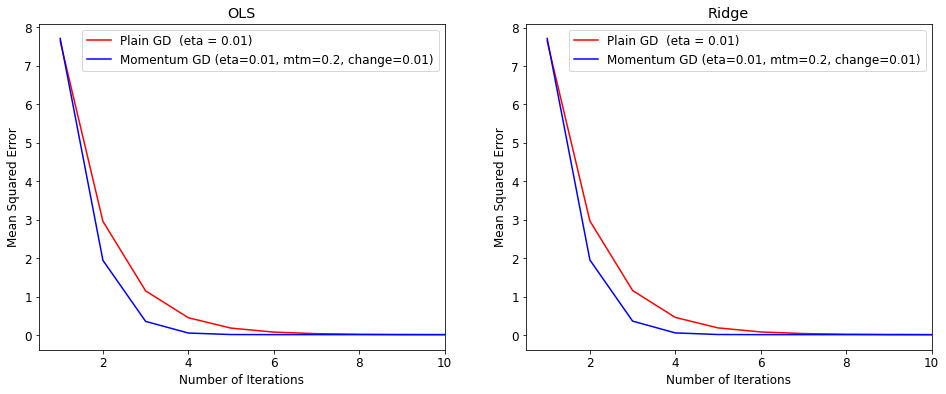

In [115]:
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].plot(range(1,101), plain_OLS, 'r', label='Plain GD  (eta = 0.01)')
ax[0].plot(range(1,101), momentum_OLS, 'b', label='Momentum GD (eta=0.01, mtm=0.2, change=0.01)')
ax[0].set_xlabel('Number of Iterations')
ax[0].set_ylabel('Mean Squared Error')
ax[0].set_title('OLS')
ax[0].legend()
ax[0].set_xlim(0.5,10)

ax[1].plot(range(1,101), plain_ridge, 'r', label='Plain GD  (eta = 0.01)')
ax[1].plot(range(1,101), momentum_ridge, 'b', label='Momentum GD (eta=0.01, mtm=0.2, change=0.01)')
ax[1].set_xlabel('Number of Iterations')
ax[1].set_ylabel('Mean Squared Error')
ax[1].set_title('Ridge')
ax[1].legend()
ax[1].set_xlim(0.5,10)
fig.savefig('GD_momentum_comparison_convergence.jpg', dpi=1000, bbox_inches='tight')

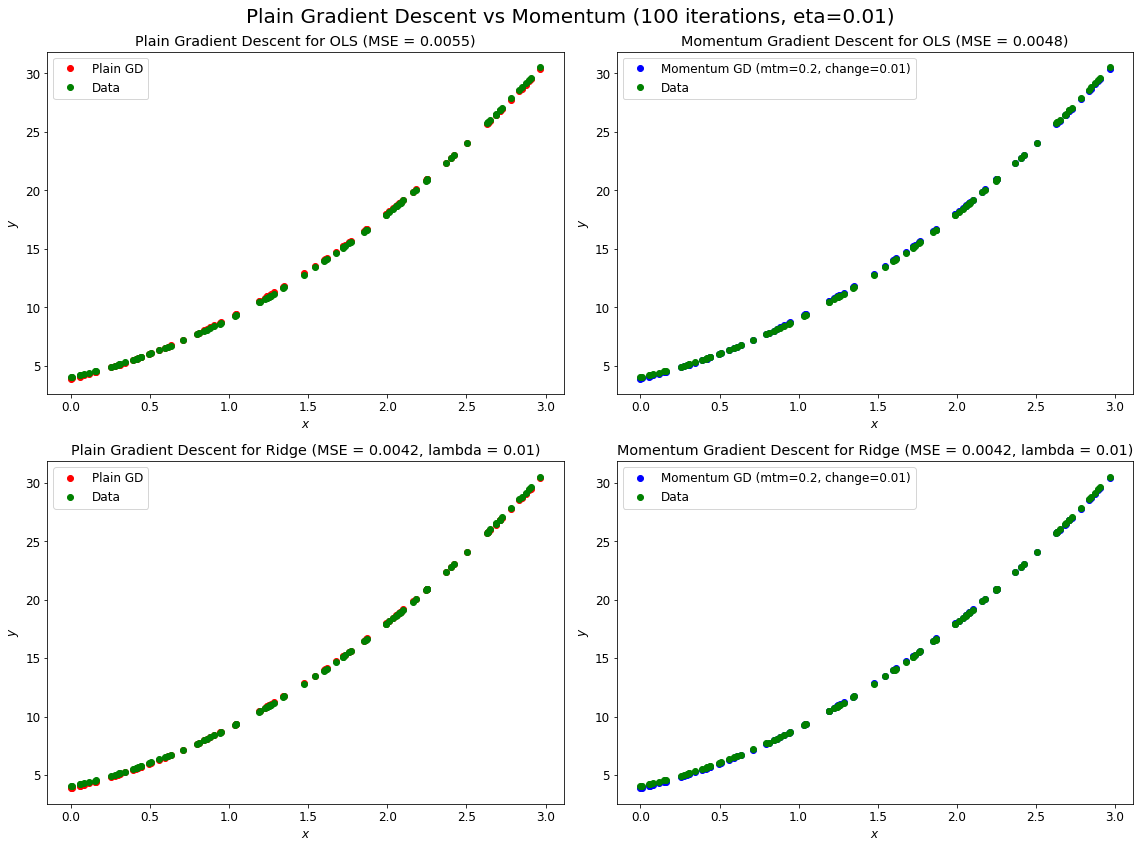

In [116]:
fig,ax = plt.subplots(2, 2, figsize=(16,12))
ax[0,0].plot(x, ypred_plain_OLS, 'ro', label='Plain GD')
ax[0,0].plot(x, y ,'go', label='Data')
ax[0,0].set_xlabel(r'$x$')
ax[0,0].set_ylabel(r'$y$')
ax[0,0].set_title('Plain Gradient Descent for OLS (MSE = '+str(round(MSE(ypred_plain_OLS, y),4))+')')
ax[0,0].legend()

ax[0,1].plot(x, ypred_momentum_OLS, 'bo', label='Momentum GD (mtm=0.2, change=0.01)')
ax[0,1].plot(x, y ,'go', label='Data')
ax[0,1].set_xlabel(r'$x$')
ax[0,1].set_ylabel(r'$y$')
ax[0,1].set_title('Momentum Gradient Descent for OLS (MSE = '+str(round(MSE(ypred_momentum_OLS, y),4))+')')
ax[0,1].legend()

ax[1,0].plot(x, ypred_plain_ridge, 'ro', label='Plain GD')
ax[1,0].plot(x, y ,'go', label='Data')
ax[1,0].set_xlabel(r'$x$')
ax[1,0].set_ylabel(r'$y$')
ax[1,0].set_title('Plain Gradient Descent for Ridge (MSE = '+str(round(MSE(ypred_plain_ridge, y),4))+', lambda = 0.01)')
ax[1,0].legend()

ax[1,1].plot(x, ypred_momentum_ridge, 'bo', label='Momentum GD (mtm=0.2, change=0.01)')
ax[1,1].plot(x, y ,'go', label='Data')
ax[1,1].set_xlabel(r'$x$')
ax[1,1].set_ylabel(r'$y$')
ax[1,1].set_title('Momentum Gradient Descent for Ridge (MSE = '+str(round(MSE(ypred_momentum_ridge, y),4))+', lambda = 0.01)')
ax[1,1].legend()
fig.suptitle('Plain Gradient Descent vs Momentum (100 iterations, eta=0.01)', fontsize=20)
plt.tight_layout()
fig.savefig('GD_momentum_comparison_polynomialplot.jpg', dpi=1000, bbox_inches='tight')

# SGD

### here we implement stochastic gradient descent and investigate convergence rate compared to standard GD, and convergence as a function of minibatch size

In [117]:
def SGD(npoints, x, y, order, lmbda, n_epochs, eta, linreg0_ridge1, minibatch_size, t0, t1, momentum, change):
    
    'performs stochastic gradient descent for a 1d polynomial'
    'npoints = number of datapoints, x = x datapoints, y = y datapoints, order = polynomial order'
    'lmbda = optional regularization parameter, n_epochs = number of epochs'
    'eta = learning rate, linreg0_ridge1 = 0 if you want linear reg, 1 if you want ridge'
    'minibatch_size = minibatch size, t0 = first adaptive learning rate parameter, t1 = second adaptive lr parameter'
    'momentum = optional momentum value, change = optional change value for momentum GD'

    X = design_matrix_1d(x, order)

    np.random.seed(4)
    beta = np.array([4, 3, 2]) + np.random.normal(0, 0.5, size=3)
    beta = np.expand_dims(beta, axis=1)

    M = minibatch_size 
    m = int(npoints/M) 
    
    for epoch in range(n_epochs):
        
        # iterate over each minibatch
        for i in range(m):
            # select out the data in each minibatch
            random_index = M*np.random.randint(m)
            xi = X[random_index:random_index+M]
            yi = y[random_index:random_index+M]

            if linreg0_ridge1 == 0:
                gradient = (2.0 / npoints) * xi.T @ (xi @ beta-yi)
            elif linreg0_ridge1 == 1:
                gradient = (2.0 / npoints) * xi.T @ (xi @ (beta)-yi) + 2 * lmbda * beta
            
            # tune the learning rate with the parameters t0 and t1
            eta = t0 / ((epoch*m+i) + t1)

            new_change = eta * gradient + momentum * change

            beta -= new_change

            change = new_change

    ypred = X @ beta

    return ypred

In [120]:
GD_epochtest = []
SGD_epochtest = []
minibatch_size = 5


for n_epochs in range(1, 101):
    y_pred_GD = GD(npoints, x, y, order, lmbda, n_epochs, eta=0.01, linreg0_ridge1=0, momentum=0.8, change=0.1)
    
    y_pred_SGD = SGD(npoints, x, y, order, lmbda, n_epochs, eta=0.01, linreg0_ridge1=0, 
                minibatch_size=minibatch_size, t0=5, t1=50, momentum=0.8, change=0.1)
    
    GD_epochtest.append(MSE(y_pred_GD, y))

    SGD_epochtest.append(MSE(y_pred_SGD, y))


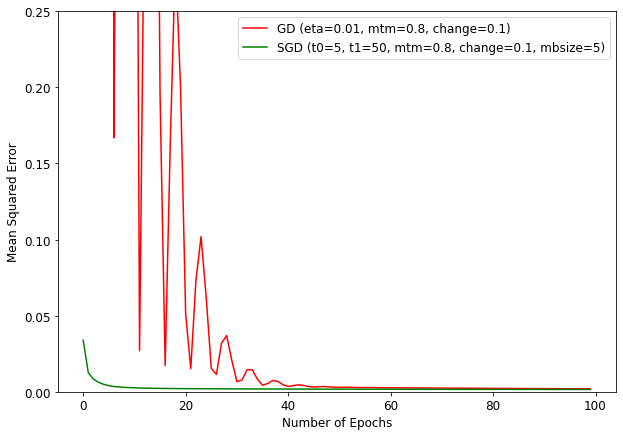

In [121]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(GD_epochtest, 'r', label='GD (eta=0.01, mtm=0.8, change=0.1)')
ax.plot(SGD_epochtest, 'g', label='SGD (t0=5, t1=50, mtm=0.8, change=0.1, mbsize=5)')
ax.set_ylim(0,0.25)
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of Epochs')
ax.legend()
plt.savefig('GD_vs_SGD_convergence.jpg', dpi=1000, bbox_inches='tight')

In [122]:
# test different minibatch sizes in order to see the effect on convergence

batchsize_SGD = np.zeros((6, 100))
count = 0
for mbsize in [1, 5, 10, 50, 75, 100]:
    MSES = []
    for n_epochs in range(1, 101):

        y_pred_SGD = SGD(npoints, x, y, order, lmbda, n_epochs, eta=0.01,
                        linreg0_ridge1=0, minibatch_size=mbsize, t0=5, t1=50, momentum=0.8, change=0.1)
        MSES.append(MSE(y_pred_SGD, y))

    batchsize_SGD[count,:] = MSES
        
    count += 1

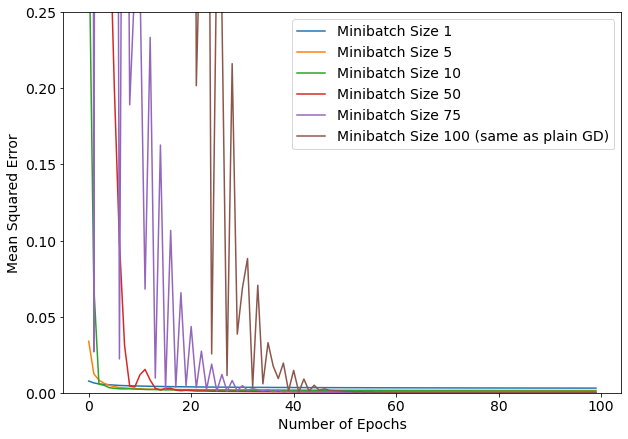

In [123]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(batchsize_SGD[0,:], label='Minibatch Size 1')
ax.plot(batchsize_SGD[1,:], label='Minibatch Size 5')
ax.plot(batchsize_SGD[2,:], label='Minibatch Size 10')
ax.plot(batchsize_SGD[3,:], label='Minibatch Size 50')
ax.plot(batchsize_SGD[4,:], label='Minibatch Size 75')
ax.plot(batchsize_SGD[5,:], label='Minibatch Size 100 (same as plain GD)')
ax.set_ylim(0,0.25)
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of Epochs')
ax.legend()
fig.savefig('SGD_batchsize_epochs.jpg', dpi=1000, bbox_inches='tight')

# Learning Rate Tuning Methods

In [125]:
def SGD_adagrad(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, minibatch_size, delta, eta):

    X = design_matrix_1d(x, order)

    Id = npoints * lmbda * np.eye((X.T @ X).shape[0])
    
    np.random.seed(7)
    beta = np.array([4, 3, 2]) + np.random.normal(0, 0.5, size=order+1)

    beta = np.expand_dims(beta, axis=1)
    
    M = minibatch_size 
    m = int(npoints/M) 
    for epoch in range(n_epochs):
        #initialize empty matrix for gradient RMS
        Giter = np.zeros(shape=(order+1,order+1))
        for i in range(m):
            random_index = M*np.random.randint(m)
            xi = X[random_index:random_index+M]
            yi = y[random_index:random_index+M]

            if linreg0_ridge1 == 0:
                gradient = (2.0 / npoints) * xi.T @ (xi @ beta-yi)
            elif linreg0_ridge1 == 1:
                gradient = (2.0 / npoints) * xi.T @ (xi @ (beta)-yi) + 2 * lmbda * beta
            
            # calculate gradient RMS
            Giter += gradient @ gradient.T

            Ginverse = np.c_[eta/(delta+np.sqrt(np.diagonal(Giter)))]
            update = np.multiply(Ginverse,gradient)

            beta -= update

    ypred = X @ beta

    return ypred

In [126]:
def SGD_RMSprop(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, minibatch_size, delta, rho, eta):

    X = design_matrix_1d(x, order)

    Id = npoints * lmbda * np.eye((X.T @ X).shape[0])
    
    np.random.seed(7)
    beta = np.array([4, 3, 2]) + np.random.normal(0, 0.5, size=order+1)
    beta = np.expand_dims(beta, axis=1)
    
    M = minibatch_size 
    m = int(npoints/M) 
    
    for epoch in range(n_epochs):
        Giter = np.zeros(shape=(order+1,order+1))
        for i in range(m):
            random_index = M*np.random.randint(m)
            xi = X[random_index:random_index+M]
            yi = y[random_index:random_index+M]

            if linreg0_ridge1 == 0:
                gradient = (2.0 / npoints) * xi.T @ (xi @ beta-yi)
            elif linreg0_ridge1 == 1:
                gradient = (2.0 / npoints) * xi.T @ (xi @ (beta)-yi) + 2 * lmbda * beta
            
            Giter_o = np.copy(Giter)
            Previous = Giter_o
            Giter += gradient @ gradient.T
        
            # calculate moving average of the gradients
            Gnew = (rho * Previous + (1-rho) * Giter)

            Ginverse = np.c_[eta / (delta + np.sqrt(np.diagonal(Gnew)))]
            update = np.multiply(Ginverse, gradient)

            beta -= update

    ypred = X @ beta

    return ypred

In [127]:
def SGD_adam(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, minibatch_size, beta1, beta2, delta, eta):

    X = design_matrix_1d(x, order)

    Id = npoints * lmbda * np.eye((X.T @ X).shape[0])

    np.random.seed(7)
    beta = np.array([4, 3, 2]) + np.random.normal(0, 0.5, size=order+1)
    beta = np.expand_dims(beta, axis=1)

    M = minibatch_size 
    m = int(npoints/M) 
    
    moment1 = np.zeros(order+1)
    moment1 = np.expand_dims(moment1, axis=1)
    moment2 = np.zeros(order+1)
    moment2 = np.expand_dims(moment2, axis=1)
    
    for epoch in range(n_epochs):

        for i in range(m):
            random_index = M*np.random.randint(m)
            xi = X[random_index:random_index+M]
            yi = y[random_index:random_index+M]


            if linreg0_ridge1 == 0:
                gradient = (2.0 / npoints) * xi.T @ (xi @ beta-yi)
            elif linreg0_ridge1 == 1:
                gradient = (2.0 / npoints) * xi.T @ (xi @ (beta)-yi) + 2 * lmbda * beta

            # calculating moving average of the gradient and gradient squared with momentum
            moment1 = beta1 * moment1 + (1.0 - beta1) * gradient
            moment2 = beta2 * moment2 + (1.0 - beta2) * gradient**2

            mhat = moment1 / (1.0 - beta1**(i+1))
            vhat = moment2  / (1.0 - beta2**(i+1))

            beta -= eta * mhat / (np.sqrt(vhat) + delta)

    ypred = X @ beta

    return ypred

In [128]:
SGD_adagrad_mse = []
SGD_RMSprop_mse = []
SGD_adam_mse = []
eta = 0.01
linreg0_ridge1 = 0
for n_epochs in range(1, 101):
    y_pred_adagrad = SGD_adagrad(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, 
                 minibatch_size=5, delta=1e-8, eta=eta)

    
    y_pred_RMSprop = SGD_RMSprop(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, 
                 minibatch_size=5, rho=0.9, delta=1e-8, eta=eta)

    y_pred_adam = SGD_adam(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, 
                 minibatch_size=5, beta1=0.7, beta2=0.8, delta=1e-8, eta=eta)

    SGD_adagrad_mse.append(MSE(y_pred_adagrad, y))
    SGD_RMSprop_mse.append(MSE(y_pred_RMSprop, y))
    SGD_adam_mse.append(MSE(y_pred_adam, y))

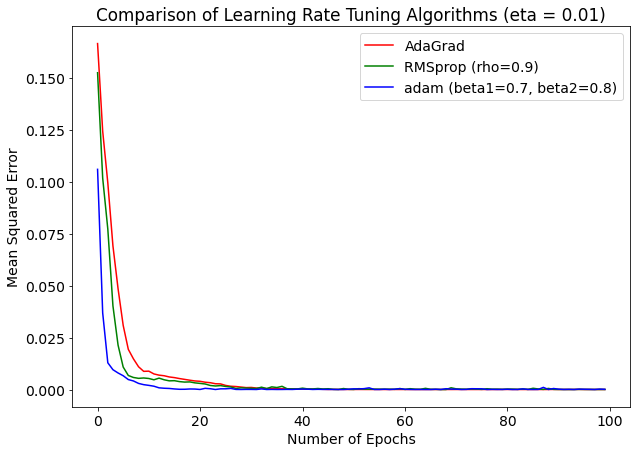

In [130]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(SGD_adagrad_mse, 'r', label='AdaGrad')
ax.plot(SGD_RMSprop_mse, 'g', label='RMSprop (rho=0.9)')
ax.plot(SGD_adam_mse, 'b', label='adam (beta1=0.7, beta2=0.8)')
#ax.set_ylim(-0.01,0.25)
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of Epochs')
ax.legend()
ax.set_title('Comparison of Learning Rate Tuning Algorithms (eta = 0.01)')
fig.savefig('learning_rate_tuning_algorithm_compare.jpg', dpi=1000, bbox_inches='tight')